In [3]:
import os
os.environ["FSSPEC_CONFIG_DIR"] = "/allen/aics/assay-dev/users/Alex/cytodata/fsspec.d"

import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nbvv
from upath import UPath as Path
from aicsimageio import AICSImage
from ome_zarr.reader import Reader
from ome_zarr.io import parse_url
import logging
logging.getLogger("bfio").setLevel(logging.ERROR)
logging.getLogger("aicsimageio").setLevel(logging.ERROR)


def read_ome_zarr(path, level=0, image_name="default"):
    path = str(path if image_name is None else Path(path) / image_name)
    reader = Reader(parse_url(path))

    node = next(iter(reader()))
    pps = node.metadata["coordinateTransformations"][0][0]["scale"][-3:]
   
    return AICSImage(
        node.data[level].compute(),
        channel_names=node.metadata["name"],
        physical_pixel_sizes=pps
    )

def rescale_image(img_data, channels):
    img_data = img_data.squeeze().astype(np.float32)
    
    for ix, channel in enumerate(channels):
        if "_seg" not in channel:
            img_data[ix] -= 1
            
            img_data[ix] = np.where(
                img_data[ix] >= 0,
                img_data[ix] / img_data.max(),
                -1
            )
    return img_data.astype(np.float16)

06-Sep-22 15:48:27 - bfio.backends - WARNING  - Java backend is not available. This could be due to a missing dependency (jpype).


## The hiPSC Single-Cell Image Dataset
Our dataset consists of 3D live-cell images of *normal human induced pluripotent stem cells (hiPSCs)*, which are a useful human cell model system. The dataset includes 25 cell lines representing major organelles, cellular structures, and compartments. Images of these cells were obtained in 3D using spinning-disk confocal microscopes and were further processed using deep learning-based segmentation. 

<img src="resources/hipsc_single_cell_image_dataset_summary.png"/>

## From FOVs to single-cell images
The hiPSC Single-Cell Image dataset consists of **215,081** single-cell images which were extracted from **18,100** fields of view (FOVs) of our cell colonies 

In [4]:
# Read the dataset
df = pd.read_parquet("s3://variance-dataset/processed/manifest.parquet")

In [11]:
some_cell = df.sample(1).iloc[0]
fov_img = AICSImage(some_cell["fov_path"]).data.squeeze()
fov_img.shape

/allen/aics/apps/hpc_shared/mod/anaconda3-5.3.0/envs/alex_cvapipe/lib/python3.8/site-packages/ome_types/_convenience.py:105: FutureWarning: The default XML parser will be changing from 'xmlschema' to 'lxml' in version 0.4.0.  To silence this warning, please provide the `parser` argument, specifying either 'lxml' (to opt into the new behavior), or'xmlschema' (to retain the old behavior).
  d = to_dict(os.fspath(xml), parser=parser, validate=validate)


(7, 65, 624, 924)

In [12]:
fov_seg_img = AICSImage(some_cell["fov_seg_path"]).data.squeeze()

/allen/aics/apps/hpc_shared/mod/anaconda3-5.3.0/envs/alex_cvapipe/lib/python3.8/site-packages/ome_types/_convenience.py:105: FutureWarning: The default XML parser will be changing from 'xmlschema' to 'lxml' in version 0.4.0.  To silence this warning, please provide the `parser` argument, specifying either 'lxml' (to opt into the new behavior), or'xmlschema' (to retain the old behavior).
  d = to_dict(os.fspath(xml), parser=parser, validate=validate)


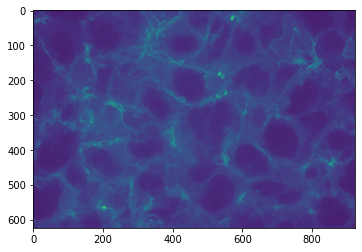

In [13]:
plt.imshow(fov_img[3,30,:,:])

Above is a z-slice (z=30) of an example FOV. We see the cell boundaries of a particular region of a colony. This image of tightly-packed hiPSCs demonstrates the challenge of obtaining single-cell images and motivates the need for the highly accurate 3D deep learned-based cell and nuclear segmentation methods we developed.

In [ ]:
#TODO: display bounding box around `some_cell`
# some_cell['bbox_min_x'], some_cell['bbox_min_y'], some_cell['bbox_max_x'], some_cell['bbox_max_y']

In [15]:
for axis in list("zyx"):
    print(axis)
    diff_quants = (df[f"bbox_max_{axis}"] - df[f"bbox_min_{axis}"]).quantile([0.1, 0.25, 0.5, 0.75, 0.9, 0.95, 0.975, 0.990])
    print(diff_quants)

z
0.100     69.0
0.250     79.0
0.500     93.0
0.750    111.0
0.900    127.0
0.950    136.0
0.975    146.0
0.990    156.0
dtype: float64
y
0.100    140.0
0.250    158.0
0.500    180.0
0.750    205.0
0.900    229.0
0.950    245.0
0.975    260.0
0.990    279.0
dtype: float64
x
0.100    212.0
0.250    239.0
0.500    273.0
0.750    313.0
0.900    354.0
0.950    381.0
0.975    406.0
0.990    438.0
dtype: float64


In [6]:
df["success"].value_counts()

True    215081
Name: success, dtype: int64

In [7]:
some_cell = df.sample(1).iloc[0]

In [8]:
full_img = read_ome_zarr(some_cell["registered_path"])

In [9]:
full_img.channel_names

['bf',
 'dna',
 'membrane',
 'structure',
 'dna_segmentation',
 'membrane_segmentation',
 'struct_segmentation_roof']

In [10]:
img_data = full_img.data.squeeze()

In [11]:
img_data.shape

(7, 136, 245, 381)

In [16]:
img_data = rescale_image(img_data, full_img.channel_names)

In [ ]:
img_data.shape

In [16]:
nbvv.volshow(
    img_data,
    spacing=[1,1,1],#full_img.physical_pixel_sizes,
    channel_names=full_img.channel_names
)

VolumeWidget(dimensions={'tile_width': 204, 'tile_height': 136, 'rows': 15, 'cols': 10, 'atlas_width': 2040, '…

In [17]:
print(f"""
Alternatively to `nbvv`, try visiting:
https://toloudis.github.io/website-3d-cell-viewer/?url=https://static-minio.a100.int.allencell.org/variance-dataset/register/{some_cell.CellId}.ome.zarr&image=default
""")


Alternatively to `nbvv`, try visiting:
https://toloudis.github.io/website-3d-cell-viewer/?url=https://static-minio.a100.int.allencell.org/variance-dataset/register/354095.ome.zarr&image=default



In [ ]:
plt.imshow(img_data[1].max(axis=0))
plt.show()

In [16]:
projections = [
    'max_projection_x',
    'max_projection_y',
    'max_projection_z',
    'mean_projection_x',
    'mean_projection_y',
    'mean_projection_z',
    'median_projection_x',
    'median_projection_y',
    'median_projection_z',
    'center_slice'
]

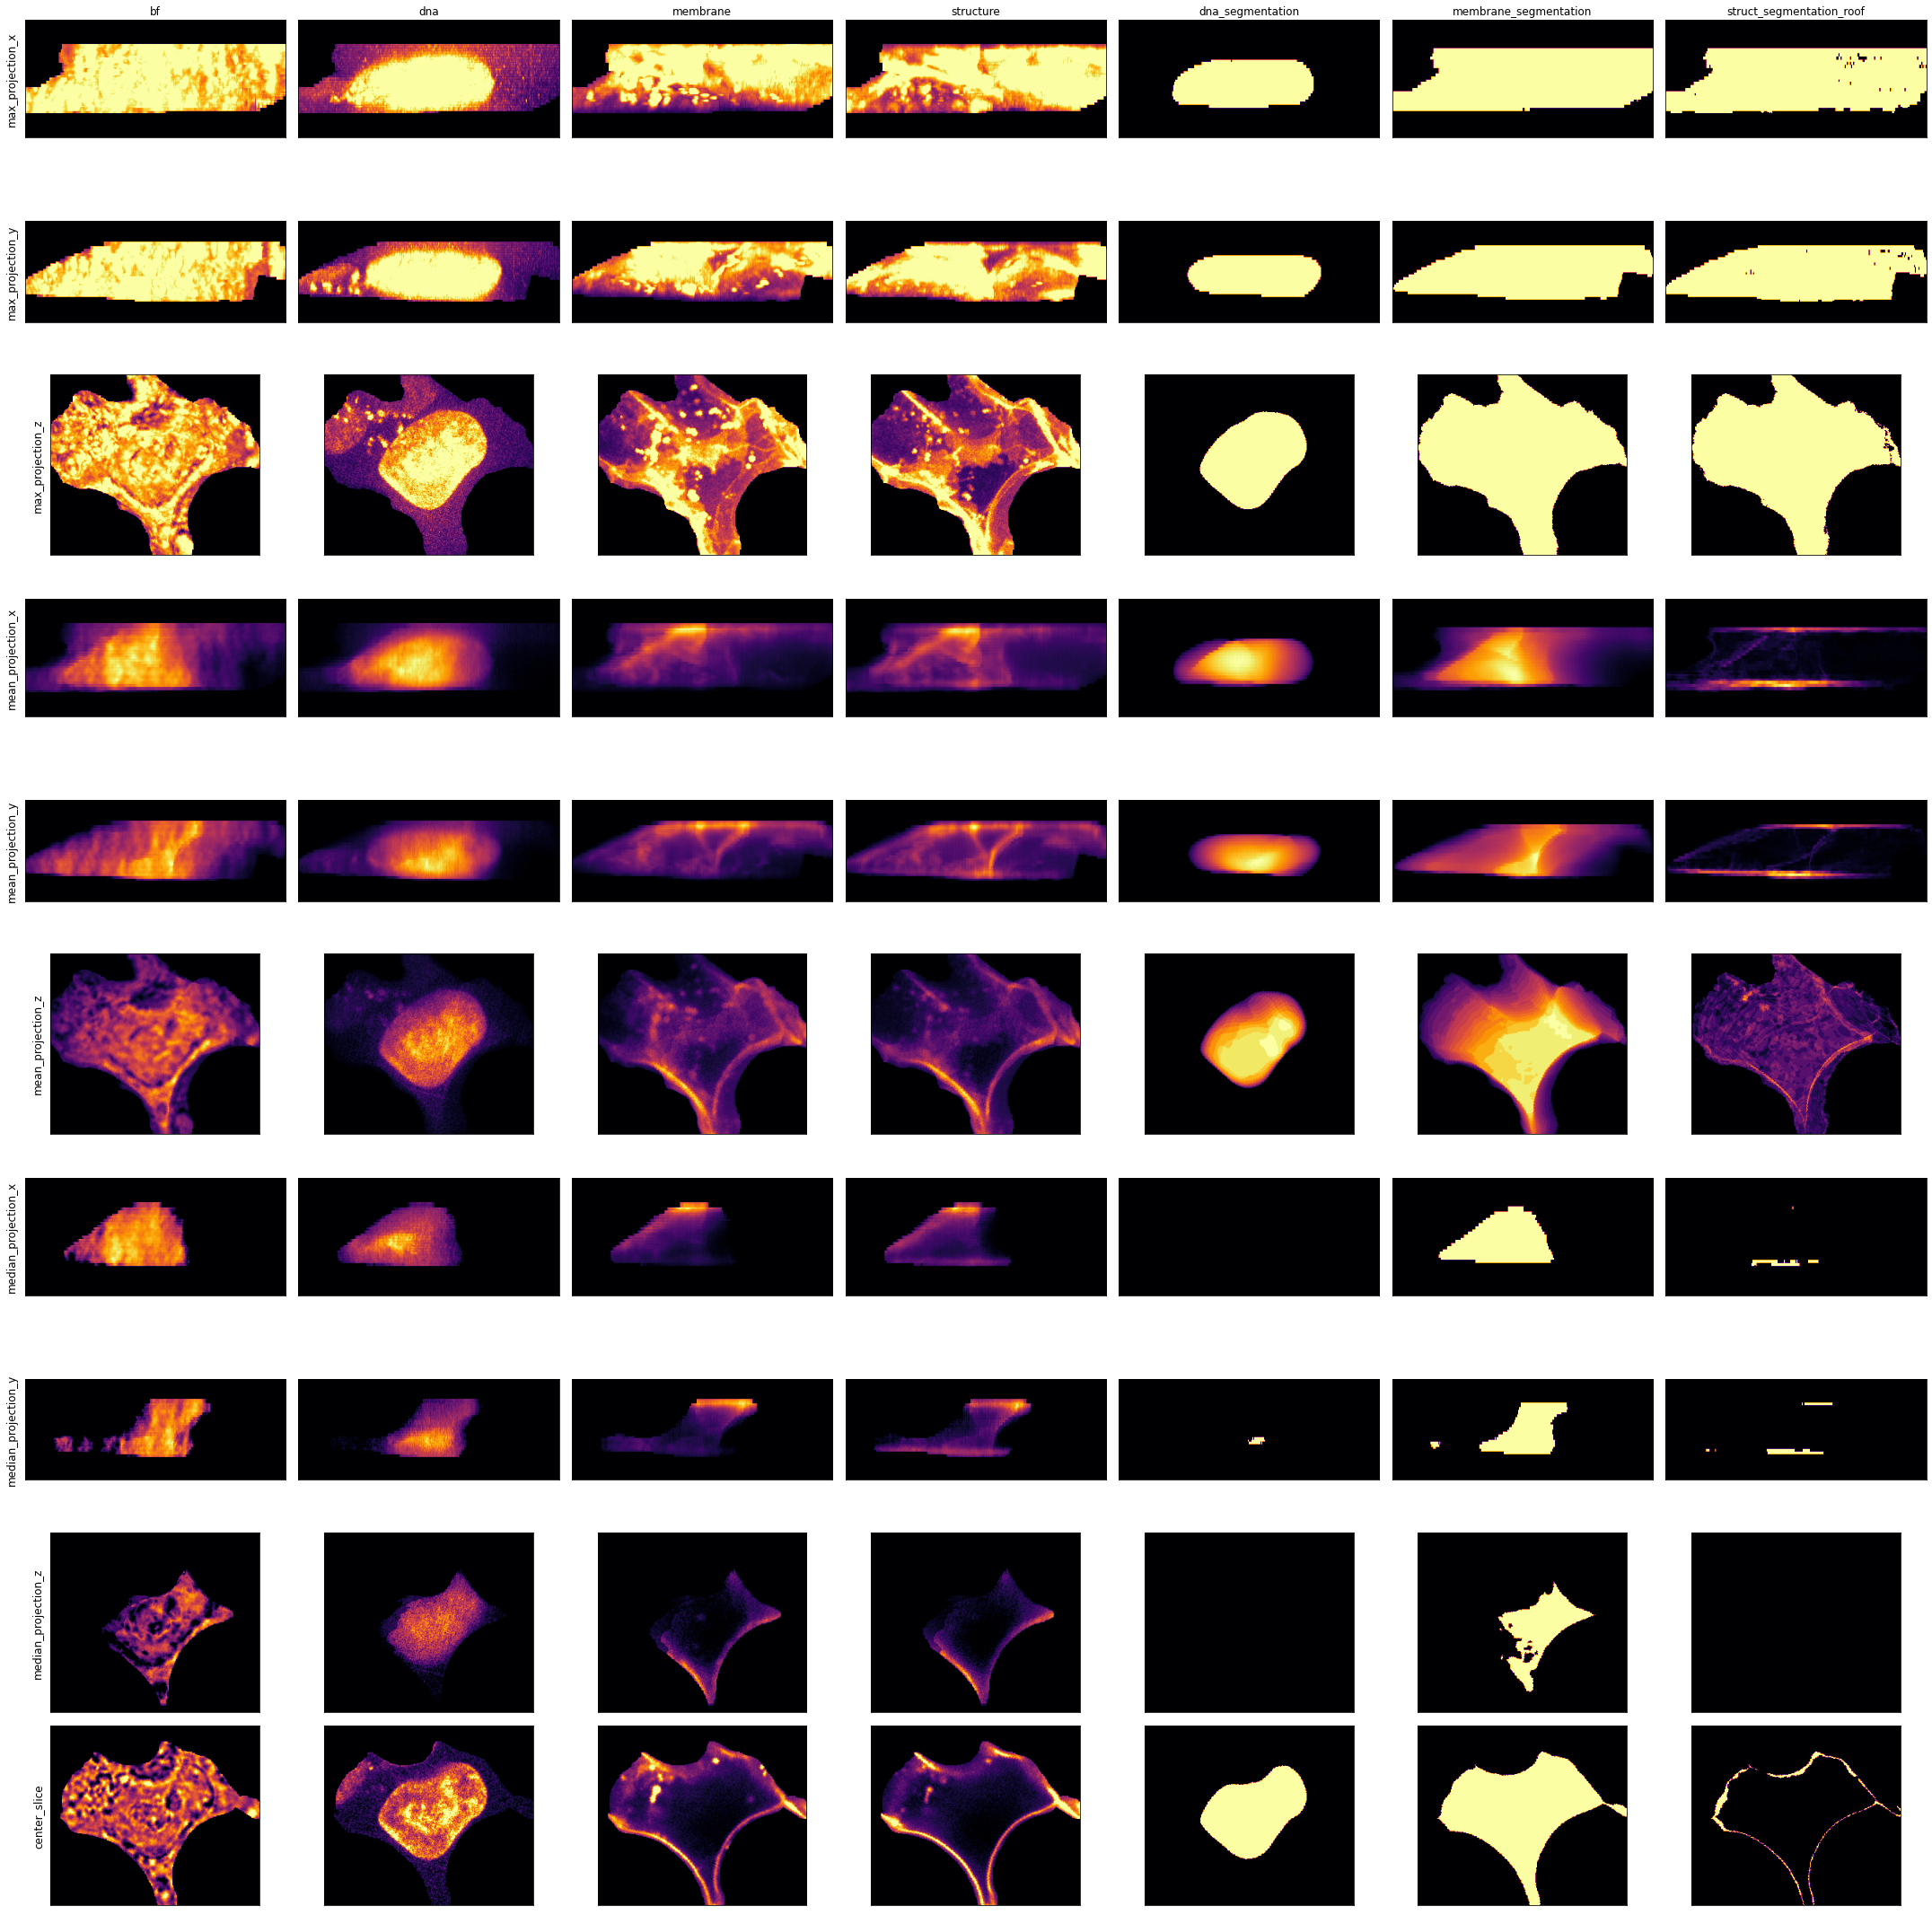

In [43]:
f, axs = plt.subplots(len(projections), 7, figsize=(30, 30))
for proj_ix, projection in enumerate(projections):
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        proj = AICSImage(some_cell[projection]).data.squeeze()
    
    for ix, channel in enumerate(full_img.channel_names):
        axs[proj_ix, ix].imshow(proj[ix], cmap="inferno")
        
        if proj_ix == 0:
            axs[proj_ix, ix].set_title(channel, size="large")
        axs[proj_ix, ix].set_xticks([])
        axs[proj_ix, ix].set_yticks([])


    axs[proj_ix, 0].set_ylabel(projection, rotation=90, size='large')

plt.tight_layout()
plt.show()